<a href="https://colab.research.google.com/github/joel-brelson/fmml_projects_and_labs/blob/main/Project_Module6_fmml20210677.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 6 Project: Covid Data Analysis with Regression

`Module Coordinator: Pranav Tadimeti`

In this project, we will use the concepts of regression and regularization we have learnt to predict early Covid-19 cases. We shall use linear regression, polynomial regression and ridge regression to obtain a reasonably good estimate of the future cases. Try experimenting with hyperparameters to obtain better results.

## Data Analysis

### 1. **Load the data** into a pandas dataframe.

In [ ]:
# Imports
import pandas as pd
import numpy  as np
import scipy.integrate

from matplotlib import pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import copy
from   sklearn.metrics       import mean_squared_error, mean_absolute_error
from   sklearn.linear_model  import LinearRegression, BayesianRidge
from   sklearn.tree          import DecisionTreeRegressor
from   sklearn.preprocessing import PolynomialFeatures

In [ ]:
path = "https://raw.githubusercontent.com/PranavTadimeti/Regression_Project/main/covid_19_data.csv"
df_orig = pd.read_csv(path)
print(df_orig.head())

   SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0  


### 2. Create a new dataframe which counts the cumulative total number of cases, the cumulative total number of deaths, and also  cumulative total number of recoveries for each date.

In [ ]:
df = copy.deepcopy(df_orig)
df.drop('Last Update',inplace=True,axis=1)
date_lst  = df.ObservationDate.unique()
date_dict = {}

for i in range(len(date_lst)):
    df_temp = df.loc[df['ObservationDate'] == date_lst[i]]
    date_dict[date_lst[i]] = df_temp
    

In [ ]:
date_tot_tup_dict = {};
for date, df in date_dict.items():
    tup_temp = (df['Confirmed'].sum(), df['Deaths'].sum(), df['Recovered'].sum())
    date_tot_tup_dict[date] = tup_temp
    

In [ ]:
df_date_tots = pd.DataFrame(date_tot_tup_dict)
df_date_tots = df_date_tots.transpose()
df_date_tots.columns = ['Confirmed', 'Deaths', 'Recovered']
print(df_date_tots)

            Confirmed   Deaths  Recovered
01/22/2020      555.0     17.0       28.0
01/23/2020      653.0     18.0       30.0
01/24/2020      941.0     26.0       36.0
01/25/2020     1438.0     42.0       39.0
01/26/2020     2118.0     56.0       52.0
...               ...      ...        ...
03/27/2020   593291.0  27198.0   130915.0
03/28/2020   660706.0  30652.0   139415.0
03/29/2020   720117.0  33925.0   149082.0
03/30/2020   782365.0  37582.0   164566.0
03/31/2020   857487.0  42107.0   178034.0

[70 rows x 3 columns]


### 3. **Plot** the total number of cases per day over time and summarize findings

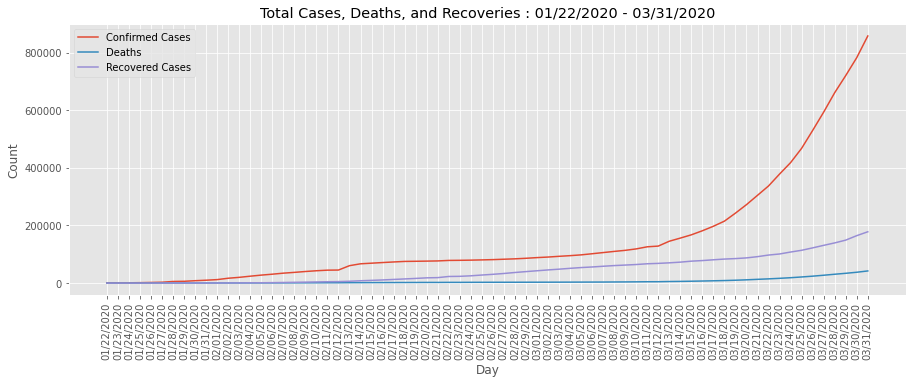

In [ ]:
plt.figure(figsize = [15,5])
plt.plot(df_date_tots['Confirmed'], label = "Confirmed Cases")
plt.plot(df_date_tots['Deaths'], label    = "Deaths")
plt.plot(df_date_tots['Recovered'], label = "Recovered Cases")

plt.legend()
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90);
start_date = str(date_lst[0]);
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Total Cases, Deaths, and Recoveries : " + start_date + " - " + fin_date);


All of the three curves seem to be exponential (start of logistic curve). The confirmed cases was obviously higher than the deaths and recovered cases. The rate of the the recovered cases seems to be higher than that of the death curve.

### 4. Create a new column in the dataframe called **“closed cases”**

In [ ]:
df_date_tots['Closed Cases'] = df_date_tots['Deaths'] + df_date_tots['Recovered']

### 5. Create a new column in the dataframe called “active cases”

In [ ]:
df_date_tots['Active Cases'] = df_date_tots['Confirmed'] - df_date_tots['Closed Cases']

### 6. Create one **plot** showing the trend of number of active cases and closed cases 

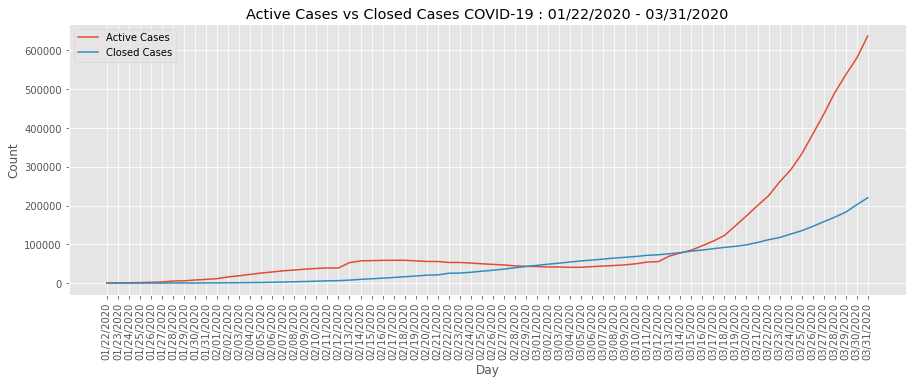

In [ ]:
plt.figure(figsize = [15,5])
plt.plot(df_date_tots['Active Cases'], label = "Active Cases")
plt.plot(df_date_tots['Closed Cases'], label = "Closed Cases")

plt.legend();
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90)
start_date = str(date_lst[0])
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Active Cases vs Closed Cases COVID-19 : " + start_date + " - " + fin_date);

The number of active cases is higher than the number of closed cases as of yet.

### 7. Growth Factor

In [ ]:
growth_len_lst = len(date_lst) - 1
confirmed_lst = df_date_tots["Confirmed"]
death_lst = df_date_tots["Deaths"]
recovered_lst = df_date_tots["Recovered"]
confGF_lst = []
deathsGF_lst = []
recovGF_lst = []
for i in range(growth_len_lst):
    confirmedGF = confirmed_lst[i+1] / confirmed_lst[i] 
    confGF_lst.append(confirmedGF)
    deathGF = death_lst[i+1] / death_lst[i] 
    deathsGF_lst.append(deathGF)
    recoveredGF = recovered_lst[i+1] / recovered_lst[i] 
    recovGF_lst.append(recoveredGF);
  

Text(0.5, 1.0, 'Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 : 01/22/2020 - 03/31/2020')

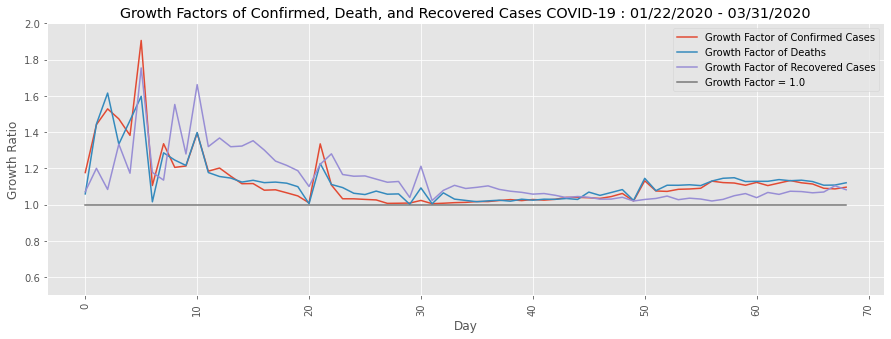

In [ ]:
plt.figure(figsize = [15,5])
plt.plot(confGF_lst, label = "Growth Factor of Confirmed Cases")
plt.plot(deathsGF_lst, label = "Growth Factor of Deaths")
plt.plot(recovGF_lst, label = "Growth Factor of Recovered Cases")
x = []
for i in range((growth_len_lst)):
    x.append(1)
plt.plot(x, label = "Growth Factor = 1.0")

#plt.grid()
plt.legend()
plt.xlabel("Day")
plt.ylabel("Growth Ratio")
plt.ylim(.5,2)
plt.xticks(rotation = 90)
start_date = str(date_lst[0])
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 : " +start_date +" - " +fin_date)

# **Part 2 - Prediction Using Linear Regression**

#### To make our data to be compatible with *sklearn* format, create a new column called “Days since” which tracks the number of days since the initial date.

In [ ]:
days_since_lst = []
for i in range(len(date_lst)):
    days_since_lst.append(i)
df_date_tots["Days Since:"] = days_since_lst
df_date_tots = df_date_tots[["Days Since:", "Confirmed", "Deaths", "Recovered", "Active Cases", "Closed Cases"]]


### 8. Take the earliest 85% of the dates as **train** and the rest as **test**

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

X = np.array(df_date_tots["Days Since:"]).reshape(-1,1)
y = np.array(df_date_tots["Confirmed"])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    shuffle = False)

### 9. We can try different regression and regularizations we have seen before

#### 9.1 Linear Regression

In [ ]:
lin_model = LinearRegression(fit_intercept = False)
lin_model.fit(X_train, y_train)
test_lin_pred = lin_model.predict(X_test)
lin_pred = lin_model.predict(X)

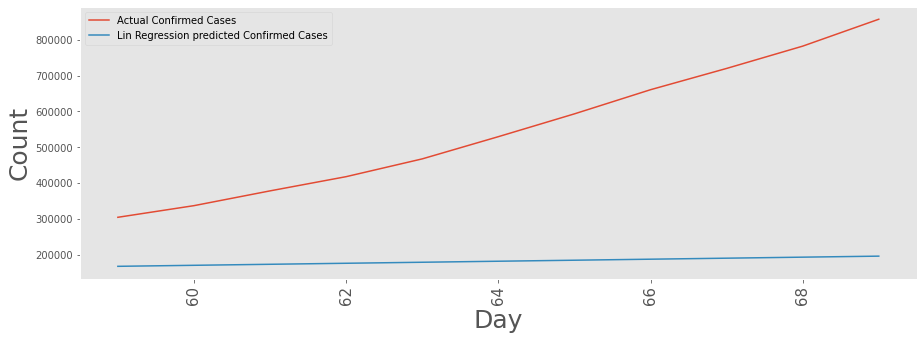

MAE: 181791.423099402
MSE: 33128805402.917187


In [ ]:
plt.figure(figsize = [15,5])
# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")
# plotting the predicited values for the future days
plt.plot(X_test,
         test_lin_pred,
         label = "Lin Regression predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print('MAE:', mean_absolute_error (test_lin_pred, X_test))
print('MSE:', mean_squared_error  (test_lin_pred, X_test))

#### Polynomial Regression

In [ ]:
poly = PolynomialFeatures(degree=5)
poly_X_train = poly.fit_transform(X_train)
poly_X_test  = poly.fit_transform(X_test)
poly_X = poly.fit_transform(X)

In [ ]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(poly_X_train, y_train)
test_poly_pred = linear_model.predict(poly_X_test)
poly_pred = linear_model.predict(poly_X)


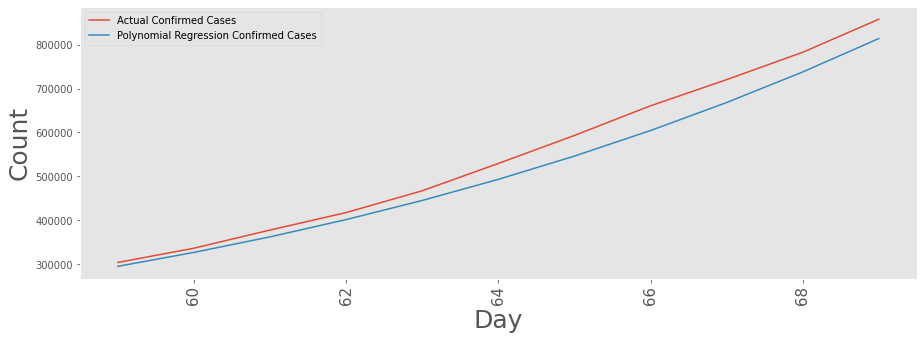

MAE: 31989.752678661967
MSE: 1314905592.3565953


In [ ]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         test_poly_pred,
         label = "Polynomial Regression Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error(test_poly_pred, y_test))
print('MSE:',mean_squared_error(test_poly_pred, y_test))

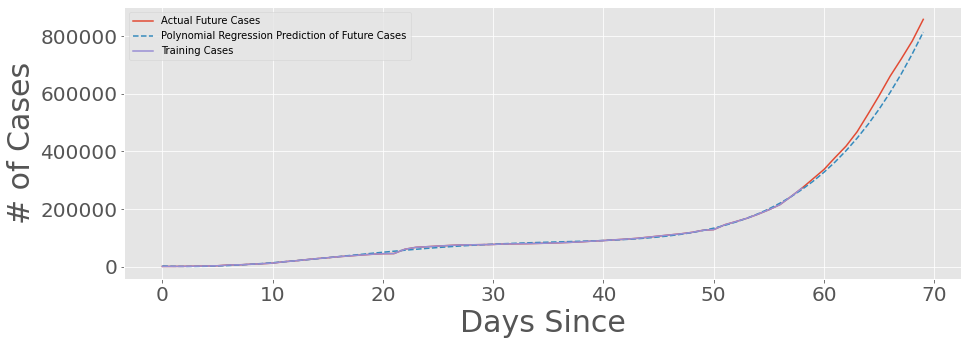

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')

plt.plot(X,
         poly_pred,
         label = 'Polynomial Regression Prediction of Future Cases',
         linestyle = "dashed")

plt.plot(X_train,
         y_train,
         label = 'Training Cases')

plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### 9.2 Ridge Regression

In [ ]:
tol      = [1e-4, 1e-3, 1e-2]
alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol,
                 'alpha_1': alpha_1,
                 'alpha_2' : alpha_2,
                 'lambda_1': lambda_1,
                 'lambda_2' : lambda_2 }

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)

bayesian_search.fit(X_train, y_train)

print(bayesian_search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.01, 'lambda_2': 0.0001, 'lambda_1': 0.0001, 'alpha_2': 1e-05, 'alpha_1': 1e-07}


In [ ]:
y_test_ridge_pred = bayesian_search.predict(X_test);
y_ridge_pred = bayesian_search.predict(X);

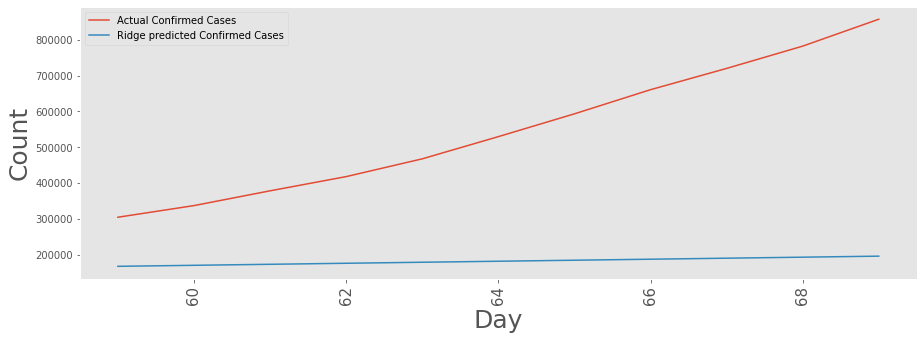

MAE: 181588.7612069584
MSE: 33054982293.837612


In [ ]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         y_test_ridge_pred,
         label = "Ridge predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error (y_test_ridge_pred, X_test))
print('MSE:', mean_squared_error  (y_test_ridge_pred, X_test))

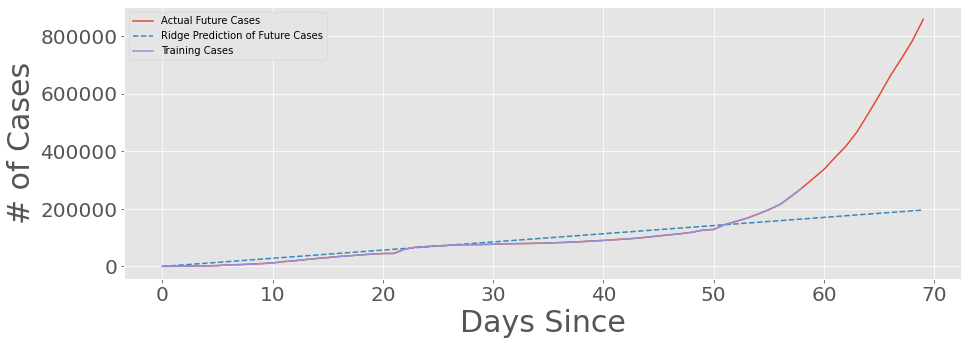

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')
plt.plot(X,
         y_ridge_pred,
         label = 'Ridge Prediction of Future Cases',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

#### Polynomial Ridge Regression

In [ ]:
bayesian_search_poly = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)


In [ ]:
bayesian_search_poly.fit(poly_X_train, y_train);
print(bayesian_search_poly.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.0001, 'lambda_2': 0.0001, 'lambda_1': 0.0001, 'alpha_2': 1e-07, 'alpha_1': 1e-06}


In [ ]:
bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_X_test)
bayesian_poly_pred = bayesian_poly_confirmed.predict(poly_X)

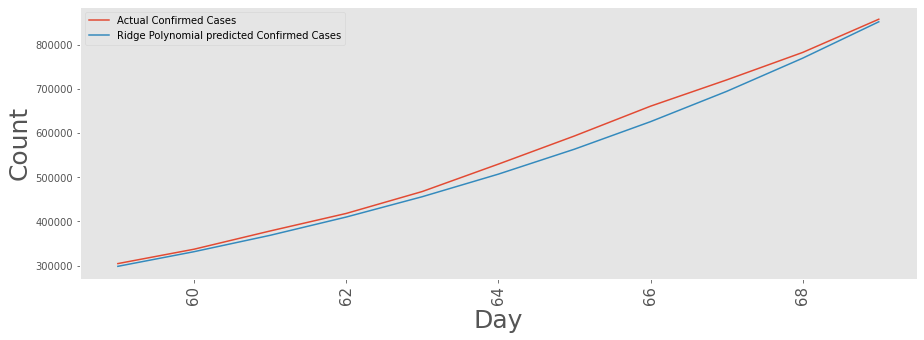

MAE: 15796.104528844653
MSE: 352565821.22058874


In [ ]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         test_poly_bayesian_pred,
         label = "Ridge Polynomial predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print ('MAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('MSE:', mean_squared_error (test_poly_bayesian_pred, y_test))

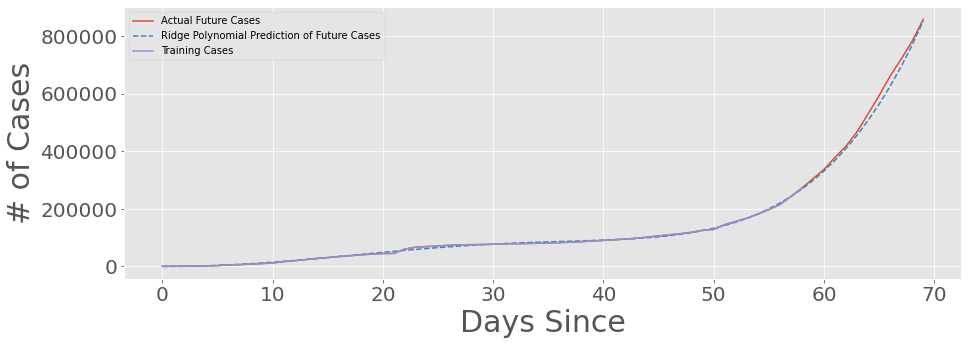

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')
plt.plot(X,
         bayesian_poly_pred,
         label = 'Ridge Polynomial Prediction of Future Cases',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
#plt.grid()
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
print("Polynomial Regression ")
print('\tMAE:', mean_absolute_error(test_poly_pred, y_test))
print('\tMSE:',mean_squared_error(test_poly_pred, y_test))

print("\nRidge Polynomial Regression ")
print ('\tMAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('\tMSE:', mean_squared_error (test_poly_bayesian_pred, y_test))

Polynomial Regression 
	MAE: 31989.752678661967
	MSE: 1314905592.3565953

Ridge Polynomial Regression 
	MAE: 15796.104528844653
	MSE: 352565821.22058874


From Mean Absolute Error and Mean Squared Error values, Ridge Polynomial Regression Model seems to be the best model.

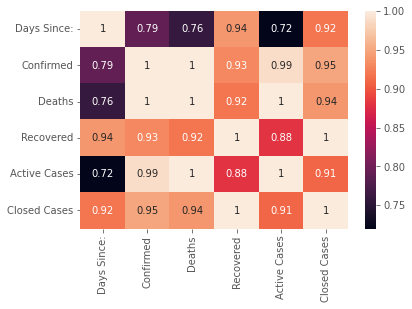

In [ ]:
import seaborn as sns
correlation_matrix = df_date_tots.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

From the above heat map, we see that Deaths and Days Since are have positive corelation(0.76) also confirmed Cases and Days since(0.79)

<Figure size 1440x720 with 0 Axes>

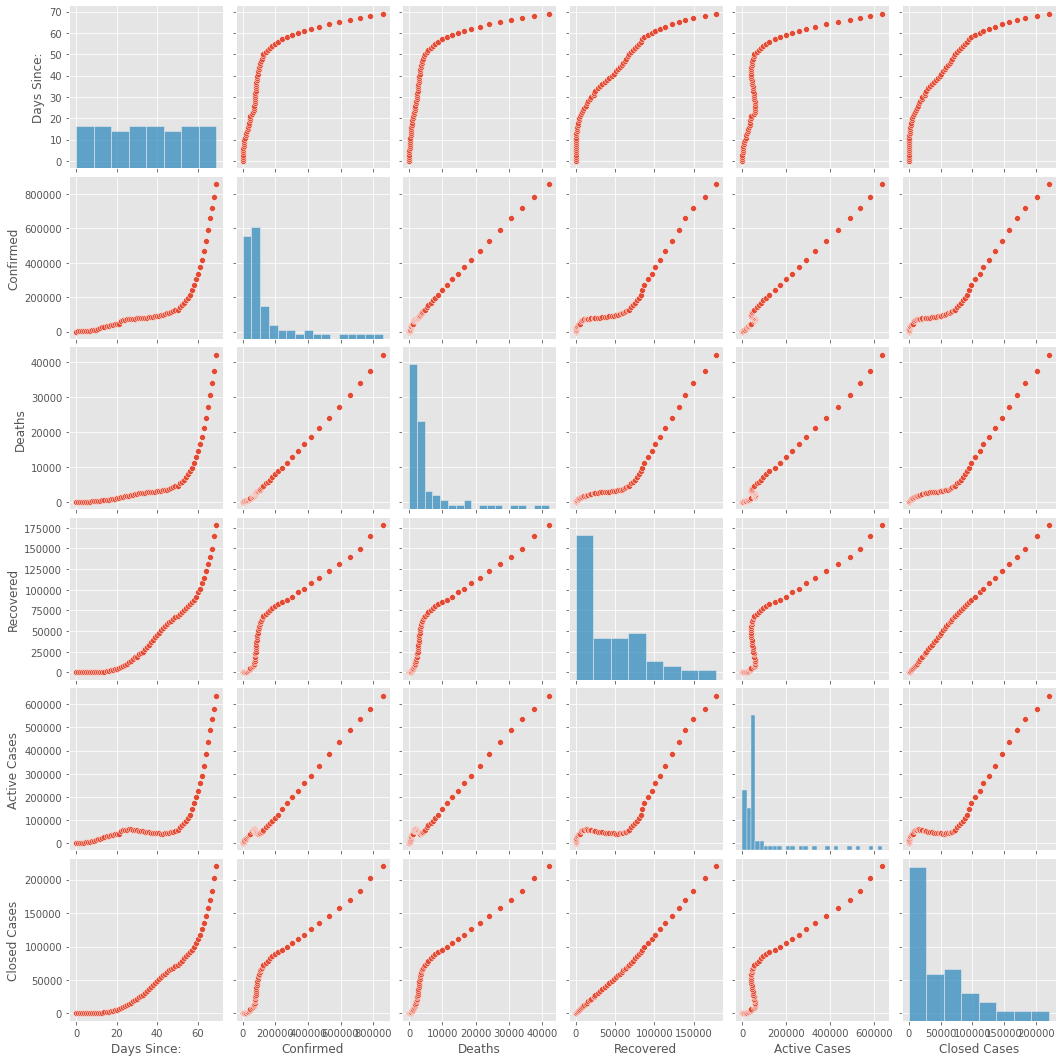

In [ ]:
data_numeric = df_date_tots.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(20, 10))
sns.pairplot(data_numeric)
plt.show()

From the above pairplot we can see that there is a linear relationship between many attributes of the dataset

## **Predicting Number of Deaths from Confirmed Cases**

In [ ]:
X = np.array(df_date_tots["Confirmed"]).reshape(-1,1)
y = np.array(df_date_tots["Deaths"])

Taking First 85% as Train and rest as Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    shuffle = False)

Linear Regression

In [ ]:
lin_model = LinearRegression(fit_intercept = False)
lin_model.fit(X_train, y_train)
test_lin_pred = lin_model.predict(X_test)
lin_pred = lin_model.predict(X)

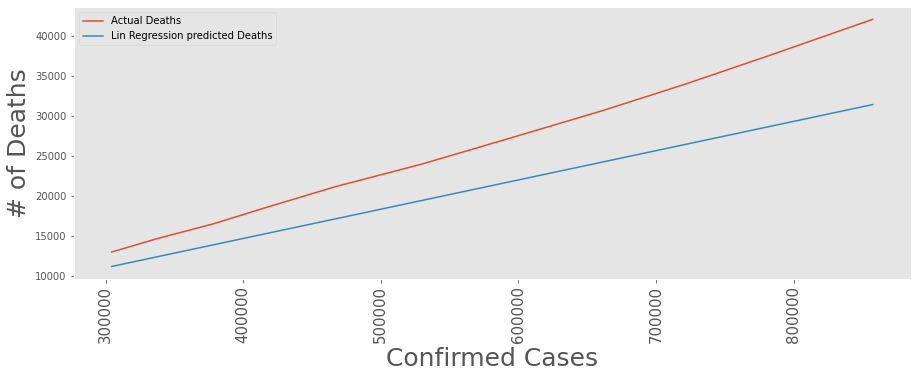

MAE: 529745.1433522638
MSE: 310272171403.374


In [ ]:
plt.figure(figsize = [15,5])
# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Deaths")
# plotting the predicited values for the future days
plt.plot(X_test,
         test_lin_pred,
         label = "Lin Regression predicted Deaths")
plt.grid();
plt.legend();
plt.xlabel("Confirmed Cases", size = 25)
plt.ylabel("# of Deaths", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print('MAE:', mean_absolute_error (test_lin_pred, X_test))
print('MSE:', mean_squared_error  (test_lin_pred, X_test))

Polynomial Regression

In [ ]:
poly = PolynomialFeatures(degree=2)
poly_X_train = poly.fit_transform(X_train)
poly_X_test  = poly.fit_transform(X_test)
poly_X = poly.fit_transform(X)

In [ ]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(poly_X_train, y_train)
test_poly_pred = linear_model.predict(poly_X_test)
poly_pred = linear_model.predict(poly_X)


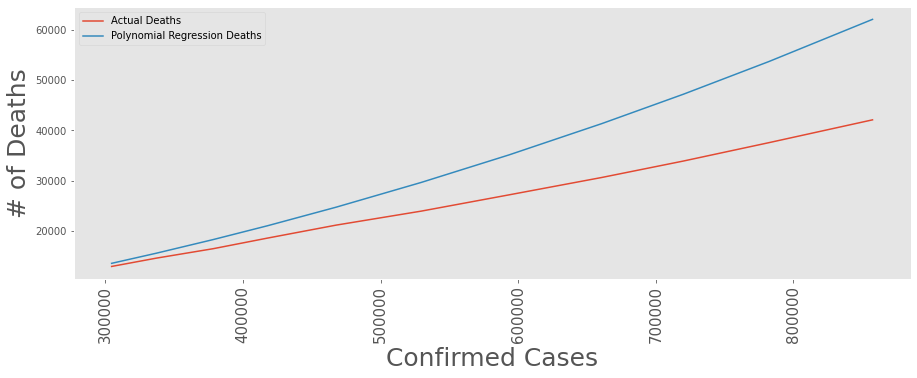

MAE: 7560.030900817314
MSE: 97172451.33560906


In [ ]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Deaths")

# plotting the predicited values for the future days
plt.plot(X_test,
         test_poly_pred,
         label = "Polynomial Regression Deaths")
plt.grid();
plt.legend();
plt.xlabel("Confirmed Cases", size = 25)
plt.ylabel("# of Deaths", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error(test_poly_pred, y_test))
print('MSE:',mean_squared_error(test_poly_pred, y_test))

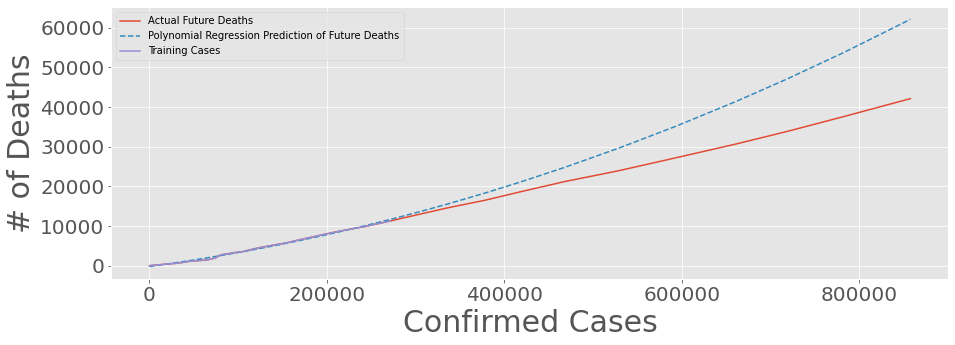

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Deaths')

plt.plot(X,
         poly_pred,
         label = 'Polynomial Regression Prediction of Future Deaths',
         linestyle = "dashed")

plt.plot(X_train,
         y_train,
         label = 'Training Cases')

plt.xlabel('Confirmed Cases', size = 30)
plt.ylabel('# of Deaths', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Ridge Regression

In [ ]:
tol      = [1e-4, 1e-3, 1e-2]
alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol,
                 'alpha_1': alpha_1,
                 'alpha_2' : alpha_2,
                 'lambda_1': lambda_1,
                 'lambda_2' : lambda_2 }

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)

bayesian_search.fit(X_train, y_train)

print(bayesian_search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.001, 'lambda_2': 0.0001, 'lambda_1': 1e-07, 'alpha_2': 1e-07, 'alpha_1': 1e-05}


In [ ]:
y_test_ridge_pred = bayesian_search.predict(X_test);
y_ridge_pred = bayesian_search.predict(X);

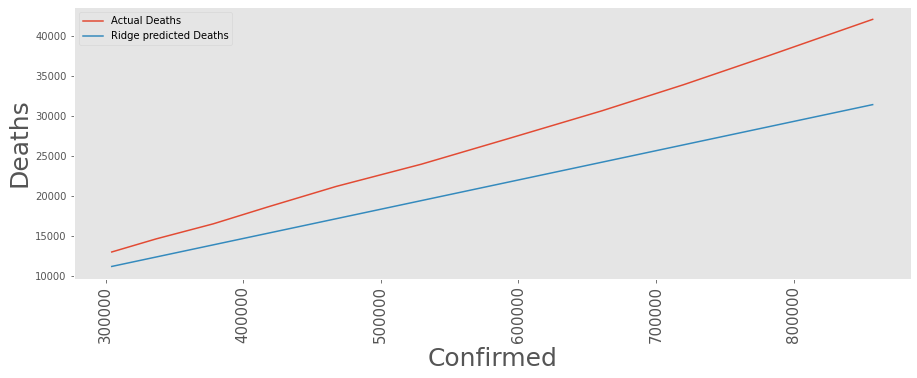

MAE: 529750.3907233656
MSE: 310278318213.0615


In [ ]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Deaths")

# plotting the predicited values for the future days
plt.plot(X_test,
         y_test_ridge_pred,
         label = "Ridge predicted Deaths")
plt.grid();
plt.legend();
plt.xlabel("Confirmed", size = 25)
plt.ylabel("Deaths", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error (y_test_ridge_pred, X_test))
print('MSE:', mean_squared_error  (y_test_ridge_pred, X_test))

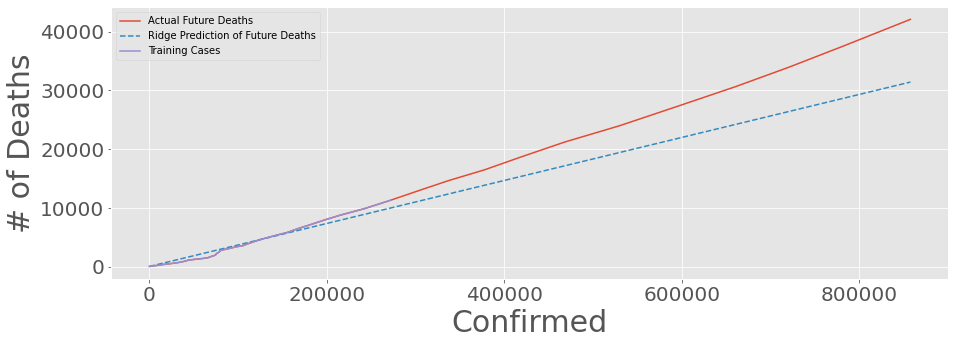

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Deaths')
plt.plot(X,
         y_ridge_pred,
         label = 'Ridge Prediction of Future Deaths',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Confirmed', size = 30)
plt.ylabel('# of Deaths', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
bayesian_search_poly = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)


In [ ]:
bayesian_search_poly.fit(poly_X_train, y_train);
print(bayesian_search_poly.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.001, 'lambda_2': 0.0001, 'lambda_1': 1e-07, 'alpha_2': 1e-05, 'alpha_1': 0.0001}


In [ ]:
bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_X_test)
bayesian_poly_pred = bayesian_poly_confirmed.predict(poly_X)

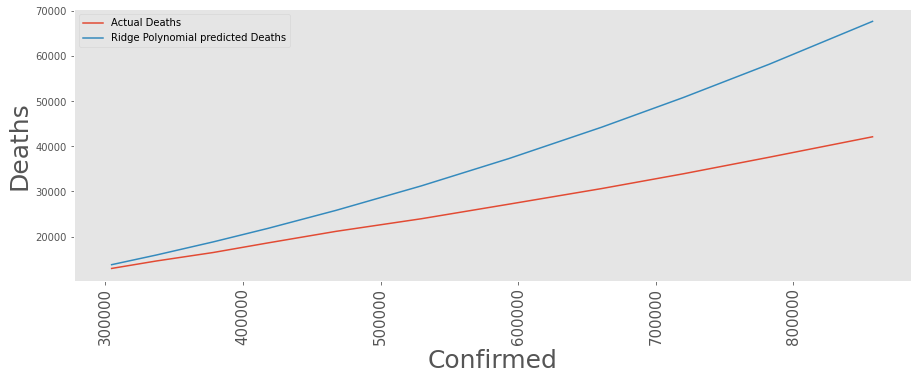

MAE: 9664.716364998823
MSE: 158184190.38036507


In [ ]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Deaths")

# plotting the predicited values for the future days
plt.plot(X_test,
         test_poly_bayesian_pred,
         label = "Ridge Polynomial predicted Deaths")
plt.grid();
plt.legend();
plt.xlabel("Confirmed", size = 25)
plt.ylabel("Deaths", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print ('MAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('MSE:', mean_squared_error (test_poly_bayesian_pred, y_test))

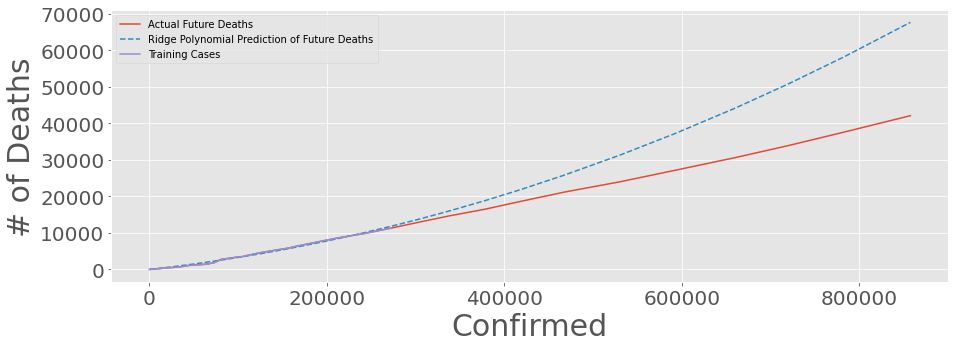

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Deaths')
plt.plot(X,
         bayesian_poly_pred,
         label = 'Ridge Polynomial Prediction of Future Deaths',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

plt.xlabel('Confirmed', size = 30)
plt.ylabel('# of Deaths', size = 30)
#plt.grid()
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
print("Polynomial Regression ")
print('\tMAE:', mean_absolute_error(test_poly_pred, y_test))
print('\tMSE:',mean_squared_error(test_poly_pred, y_test))

print("\nRidge Polynomial Regression ")
print ('\tMAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('\tMSE:', mean_squared_error (test_poly_bayesian_pred, y_test))

Polynomial Regression 
	MAE: 7560.030900817314
	MSE: 97172451.33560906

Ridge Polynomial Regression 
	MAE: 9664.716364998823
	MSE: 158184190.38036507


From Mean Absolute Error and Mean Squared Error values, Polynomial Regression Model seems to be a better model for predicting number of Deaths.